In [1]:
import argparse
import json
import tensorflow as tf
import numpy as np
import h5py
import copy
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
from evtk import hl
#from mayavi import mlab
#mlab.init_notebook('itk')

from fr3D.train.utils import setup_datasets
from fr3D.data.utils import get_normalization
from fr3D.models import ConvAutoencoder, ConvAutoencoderCGAN, ConvAutoencoderC

tf.keras.backend.set_image_data_format('channels_last')

def check_in_polygon(pts, vertices):
    path = mplPath.Path(vertices)
    return path.contains_points(pts)

def mape_with_threshold(yp, yt, pcterror_threshold=np.inf, max_magnitude_threshold=0.0, eps=1e-7):
    pct_errors = 100*tf.abs((yp-yt)/(eps + yt))
    pcterror_mask = pct_errors < pcterror_threshold
    max_magnitude_mask = tf.logical_not(tf.abs(yt) < (max_magnitude_threshold*tf.reduce_max(tf.abs(yt))))
    filtering_indices = tf.where(tf.logical_and(pcterror_mask, max_magnitude_mask))
    filtered_pcterrors = tf.gather_nd(pct_errors, filtering_indices)
    return float(tf.reduce_mean(filtered_pcterrors))

def get_normalization_type(node_configs):
    normalization_spec = {'method': None}
    for node in node_configs:
        if node['nodetype'] == 'normalize':
            normalization_spec = node['normalization_spec']
            break
    normalizer = get_normalization(**normalization_spec, batch_mode=True)
    return normalizer

def export_vtk(path, c, **fields):
    x = c[...,0].reshape(-1)
    y = c[...,1].reshape(-1)
    z = c[...,2].reshape(-1)
    
    innerx = c[:1,...,0].reshape(-1)
    innery = c[:1,...,1].reshape(-1)
    innerz = c[:1,...,2].reshape(-1)
    
    data = {}
    for f in fields:
        data[f] = fields[f].reshape(-1).copy()
    hl.pointsToVTK(path, x, y, z, data = data)
    hl.pointsToVTK(path+'obstacle', innerx, innery, innerz, data = {'obstacle': np.zeros(c[:1].shape[:-1])})

In [90]:
Re = 500
expt_variables = ['Pressure', 'U', 'V', 'W']

dataset_path = f'/fr3D/postprocessed/annulus_64_plane.h5'

#ConvAutoencoderC
experiment_configs = {expt_variable:f'/fr3D/configs/training_piv/ConvAutoencoderC_{expt_variable}.json' for expt_variable in expt_variables}
weights_paths = {expt_variable:f'/storage/weights{Re}piv/ConvAutoencoderC_{expt_variable}_Annulus64/ConvAutoencoderC_{expt_variable}_Annulus64.h5' for expt_variable in expt_variables}



datasetf = h5py.File(dataset_path,'r')

shuf_buf = 1

train_datasets = {}
test_datasets = {}
sensor_shapes = {}
full_field_shapes = {}
normalizers = {}

for expt_variable in experiment_configs:
    config = json.load(open(experiment_configs[expt_variable],'r'))
    train_datasets[expt_variable], test_datasets[expt_variable] = setup_datasets(config, dataset_path, shuf_buf, case_names=True, evaluation=True)
    sensor_shapes[expt_variable] = train_datasets[expt_variable].element_spec[0][0].shape
    full_field_shapes[expt_variable] = train_datasets[expt_variable].element_spec[0][1].shape
    normalizers[expt_variable] = get_normalization_type(config['dataset']['node_configurations'])
    
dataset_iterators = {v: iter(test_datasets[v]) for v in test_datasets}

Training geometries: ('shape_69', 'shape_33', 'shape_37', 'shape_374', 'shape_239', 'shape_224', 'shape_160', 'shape_237', 'shape_135', 'cylinder', 'shape_152', 'shape_186', 'shape_92', 'shape_21', 'shape_58', 'shape_110', 'shape_88', 'shape_59', 'shape_14', 'shape_197', 'shape_55', 'shape_8', 'shape_170', 'shape_234', 'shape_43', 'shape_149', 'shape_228', 'shape_48', 'shape_130', 'shape_90', 'shape_137', 'shape_84', 'shape_361', 'shape_182', 'shape_68', 'shape_113', 'shape_244', 'shape_327', 'shape_216', 'shape_15', 'shape_63', 'shape_213', 'shape_126', 'shape_236', 'shape_50', 'shape_18', 'shape_157', 'shape_89', 'shape_17', 'shape_355', 'shape_29', 'shape_146', 'shape_164', 'shape_11', 'shape_150', 'shape_220', 'shape_13', 'shape_60', 'shape_12', 'shape_369', 'shape_218', 'shape_78', 'shape_331', 'shape_97', 'shape_329', 'shape_31', 'shape_39', 'shape_241', 'shape_41', 'shape_346', 'shape_94', 'shape_61', 'shape_23', 'shape_339', 'shape_255', 'shape_83', 'shape_338', 'shape_54', 'sh

In [3]:
models = {}

for v in expt_variables:
    config = json.load(open(experiment_configs[v],'r'))
    model = ConvAutoencoderC(dense_input_units=sensor_shapes[v][1],
                             autoencoder_input_shape=full_field_shapes[v][1:],
                             **config['model'])
    loss_fn = "mse"#tf.keras.losses.get(config['training']['loss'])
    model.compile(l_optimizer= tf.keras.optimizers.get(config['training']['l_optimizer']),
                  loss=loss_fn,
                  optimizer = tf.keras.optimizers.get(config['training']['ae_optimizer']),
                  metrics = config['training'].get('metrics', None))
    model.load_weights(weights_paths[v])
    models[v] = model

In [114]:
get_new = True
idx = 0

inps = {}
targets = {}
ntargets = {}
norm_params = {}
case_names = {}
preds = {}
npreds = {}
ae_preds = {}
nae_preds = {}

for v in expt_variables:
    if get_new:
        for _ in range(34):
            (inp, target, norm_param), case_name = next(dataset_iterators[v])
        pred = models[v](inp,autoencode=False)
        ae_pred = models[v](target,autoencode=True)
        print(f'MAE error for {v}: {tf.reduce_mean(tf.abs(pred-target))}')
        ntarget = normalizers[v].undo(target, norm_param[:,0,:])
        npred = normalizers[v].undo(pred, norm_param[:,0,:])
        nae_pred = normalizers[v].undo(ae_pred, norm_param[:,0,:])
        
        print(f'Mean {v} stddev along z axis: {tf.reduce_max(tf.math.reduce_std(ntarget[idx,...,0], axis=-1))}')

    inps[v] = inp[idx]
    targets['gt'+v] = target[idx,...,0].numpy()
    ntargets['gt'+v] = ntarget[idx,...,0].numpy()
    norm_params[v] = norm_param[idx]
    case_names[v] = case_name[idx].numpy()
    preds['pred'+v] = pred[idx,...,0].numpy()
    npreds['pred'+v] = npred[idx,...,0].numpy()
    ae_preds['aepred'+v] = ae_pred[idx,...,0].numpy()
    nae_preds['aepred'+v] = nae_pred[idx,...,0].numpy()


assert len(set(case_names.values()))==1
case_name_str = list(case_names.values())[0].decode()
print(case_name_str)
coords = datasetf[case_name_str]['full_field_coords']

MAE error for Pressure: 0.034226007759571075
Mean Pressure stddev along z axis: 0.4287185072898865
MAE error for U: 0.016036788001656532
Mean U stddev along z axis: 0.4416118264198303
MAE error for V: 0.01603352092206478
Mean V stddev along z axis: 0.5854165554046631
MAE error for W: 0.01779903657734394
Mean W stddev along z axis: 0.4900193512439728
shape_95


In [117]:
export_vtk(f"/storage/paper/qcrit_planes/qcrit_{case_name_str}", coords, **ntargets, **nae_preds, **npreds)

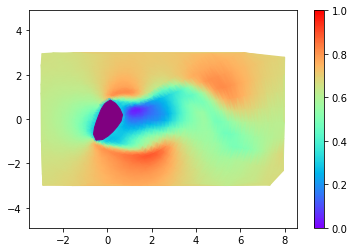

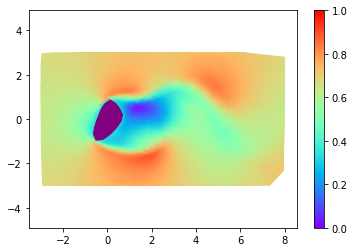

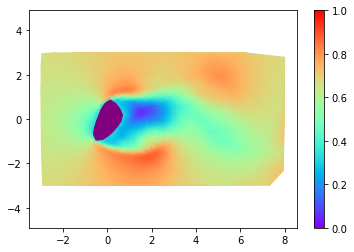

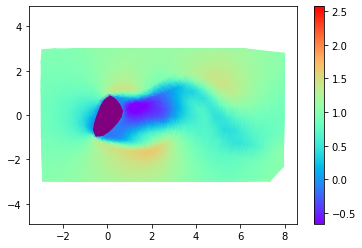

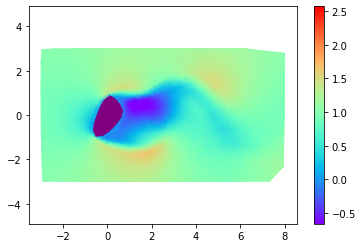

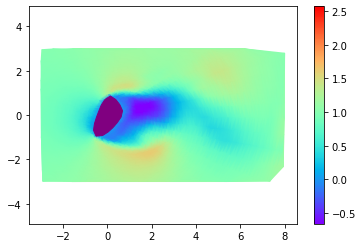

shape_95 U stats:
==Slice % err==
5.0398173332214355
4.12522029876709
==Whole snapshot % err==
4.135442733764648
2.733527898788452
==Slice % err unnormalized==
11.714795112609863
11.290417671203613
==Whole snapshot % err unnormalized==
10.196832656860352
7.651615142822266


In [116]:
idx=13
zsl=32

vmax = 1.0
vmin = 0.0

v = 'U'

stdf = 5.0
meann = tf.reduce_mean(ntargets['gt'+v][:,:,zsl])
stdn = tf.math.reduce_std(ntargets['gt'+v][:,:,zsl])
vmaxn = meann+stdf*stdn
vminn = meann-stdf*stdn


coords = datasetf[case_name_str]['full_field_coords']
x = np.reshape(coords[:,:,zsl,0],[-1])
y = np.reshape(coords[:,:,zsl,1],[-1])

p = np.reshape(preds['pred'+v][:,:,zsl], [-1])
pn = np.reshape(npreds['pred'+v][:,:,zsl], [-1])
ap = np.reshape(ae_preds['aepred'+v][:,:,zsl], [-1])
apn = np.reshape(nae_preds['aepred'+v][:,:,zsl], [-1])
t = np.reshape(targets['gt'+v][:,:,zsl], [-1])
tn = np.reshape(ntargets['gt'+v][:,:,zsl], [-1])

outer_polygon = [(-3,3), (-3,-3), (8,-3), (8,3)]
spatialmask = check_in_polygon(np.stack([x,y],-1), outer_polygon)
spatialmasked_indices = np.where(spatialmask)[0]
x = x[spatialmasked_indices]
y = y[spatialmasked_indices]
p = p[spatialmasked_indices]
pn = pn[spatialmasked_indices]
ap = ap[spatialmasked_indices]
apn = apn[spatialmasked_indices]
t = t[spatialmasked_indices]
tn = tn[spatialmasked_indices]

polygon_vertices = datasetf[case_name_str]['full_field_coords'][0,:,zsl]

#Normalized plots
plt.figure()
plt.tripcolor(x,y,p, shading='gouraud', cmap='rainbow', vmax = vmax, vmin = vmin)
plt.fill(polygon_vertices[...,0], polygon_vertices[...,1], color='purple')
plt.colorbar()
plt.axis('equal')
plt.show()
plt.close()

plt.figure()
plt.tripcolor(x,y,ap, shading='gouraud', cmap='rainbow', vmax = vmax, vmin = vmin)
plt.fill(polygon_vertices[...,0], polygon_vertices[...,1], color='purple')
plt.colorbar()
plt.axis('equal')
plt.show()
plt.close()

plt.figure()
plt.tripcolor(x,y,t, shading='gouraud', cmap='rainbow', vmax = vmax, vmin = vmin)
plt.fill(polygon_vertices[...,0], polygon_vertices[...,1], color='purple')
plt.colorbar()
plt.axis('equal')
plt.show()
plt.close()

#Unnormalized plots
plt.figure()
plt.tripcolor(x,y,pn, shading='gouraud', cmap='rainbow', vmax = vmaxn, vmin = vminn)
plt.fill(polygon_vertices[...,0], polygon_vertices[...,1], color='purple')
plt.colorbar()
plt.axis('equal')
plt.show()
plt.close()

plt.figure()
plt.tripcolor(x,y,apn, shading='gouraud', cmap='rainbow', vmax = vmaxn, vmin = vminn)
plt.fill(polygon_vertices[...,0], polygon_vertices[...,1], color='purple')
plt.colorbar()
plt.axis('equal')
plt.show()
plt.close()

plt.figure()
plt.tripcolor(x,y,tn, shading='gouraud', cmap='rainbow', vmax = vmaxn, vmin = vminn)
plt.fill(polygon_vertices[...,0], polygon_vertices[...,1], color='purple')
plt.colorbar()
plt.axis('equal')
plt.show()
plt.close()

print(f'{case_name_str} {v} stats:')
print("==Slice % err==")
print(mape_with_threshold(p,t,pcterror_threshold=200))
print(mape_with_threshold(ap,t,pcterror_threshold=200))
print("==Whole snapshot % err==")
print(mape_with_threshold(preds['pred'+v][idx],targets['gt'+v][idx],pcterror_threshold=200))
print(mape_with_threshold(ae_preds['aepred'+v][idx],targets['gt'+v][idx],pcterror_threshold=200))
print("==Slice % err unnormalized==")
print(mape_with_threshold(pn,tn,pcterror_threshold=200))
print(mape_with_threshold(apn,tn,pcterror_threshold=200))
print("==Whole snapshot % err unnormalized==")
print(mape_with_threshold(npreds['pred'+v][idx],ntargets['gt'+v][idx],pcterror_threshold=200))
print(mape_with_threshold(nae_preds['aepred'+v][idx],ntargets['gt'+v][idx],pcterror_threshold=200))